In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256 #image size will be 256x256
CHANNELS=3 #we will use rgb image for this dataset
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [5]:
# name of the 3 class belong to the directory
classes_name=dataset.class_names
classes_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Image Visulization

(32, 256, 256, 3)
[0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 2 0 2 0 1 0 1 1 1 1 1 0 1 0 0]


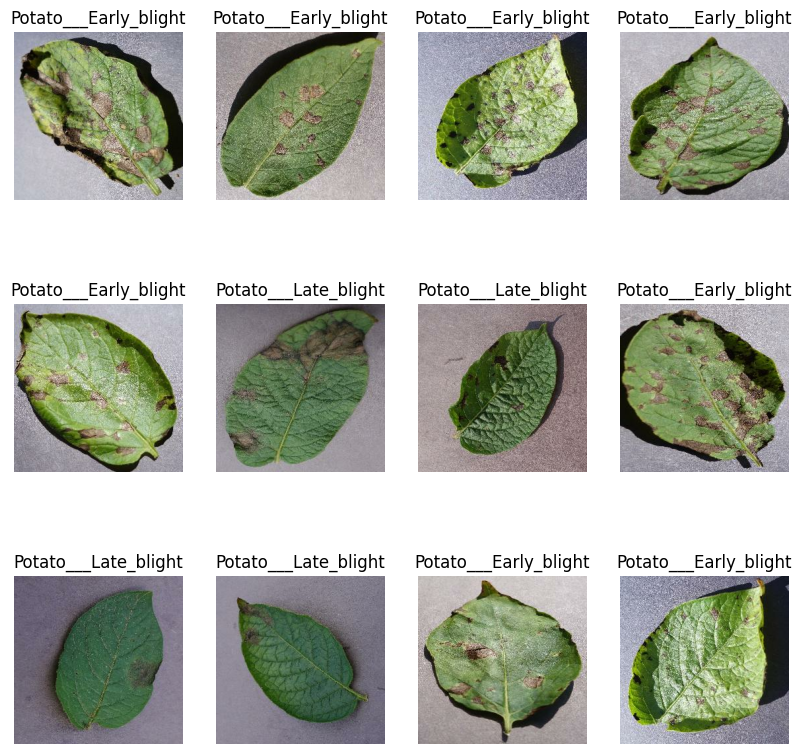

In [12]:
plt.figure(figsize=(10,10))

for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes_name[labels_batch[i]])
        plt.axis("off")


In [17]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split) ==1
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

## Cache , Shuffle and Prefetch

In [22]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch[0].numpy().shape)

[[[132. 123. 128.]
  [120. 111. 116.]
  [121. 112. 117.]
  ...
  [154. 148. 152.]
  [158. 152. 156.]
  [163. 157. 161.]]

 [[125. 116. 121.]
  [141. 132. 137.]
  [137. 128. 133.]
  ...
  [164. 158. 162.]
  [163. 157. 161.]
  [162. 156. 160.]]

 [[118. 109. 114.]
  [125. 116. 121.]
  [115. 106. 111.]
  ...
  [171. 165. 169.]
  [170. 164. 168.]
  [167. 161. 165.]]

 ...

 [[117. 107. 115.]
  [159. 149. 157.]
  [120. 110. 118.]
  ...
  [181. 176. 182.]
  [180. 175. 181.]
  [178. 173. 179.]]

 [[125. 115. 123.]
  [139. 129. 137.]
  [150. 140. 148.]
  ...
  [172. 167. 173.]
  [169. 164. 170.]
  [163. 158. 164.]]

 [[134. 124. 132.]
  [132. 122. 130.]
  [150. 140. 148.]
  ...
  [180. 175. 181.]
  [175. 170. 176.]
  [167. 162. 168.]]]
(256, 256, 3)


## Resize and Rescalling

In [27]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Augmentation

In [28]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [36]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 82s 1s/step - loss: 0.9061 - accuracy: 0.5110 - val_loss: 0.9176 - val_accuracy: 0.5677
Epoch 2/50
54/54 [==============================] - 83s 2s/step - loss: 0.6789 - accuracy: 0.6933 - val_loss: 0.6567 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 70s 1s/step - loss: 0.5063 - accuracy: 0.7749 - val_loss: 0.4577 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 69s 1s/step - loss: 0.3666 - accuracy: 0.8478 - val_loss: 0.4354 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 70s 1s/step - loss: 0.2729 - accuracy: 0.8900 - val_loss: 0.2417 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 69s 1s/step - loss: 0.2085 - accuracy: 0.9178 - val_loss: 0.3177 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 69s 1s/step - loss: 0.1812 - accuracy: 0.9242 - val_loss: 0.1557 - val_accuracy: 0.9323
Epoch 8/50
54/54 [==

In [42]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 251ms/step - loss: 0.0131 - accuracy: 0.9961


In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
history.history['loss']

[0.9060829281806946,
 0.6788741946220398,
 0.5063034296035767,
 0.36658766865730286,
 0.2729324400424957,
 0.20854252576828003,
 0.18124042451381683,
 0.19574984908103943,
 0.14301294088363647,
 0.16679304838180542,
 0.10937739908695221,
 0.10045705735683441,
 0.1029457077383995,
 0.08972326666116714,
 0.07701872289180756,
 0.09317793697118759,
 0.08131926506757736,
 0.08119862526655197,
 0.04681801050901413,
 0.10934999585151672,
 0.0899057686328888,
 0.08171671628952026,
 0.044403549283742905,
 0.03772495687007904,
 0.024239761754870415,
 0.05090174823999405,
 0.039996299892663956,
 0.026784203946590424,
 0.03175119683146477,
 0.02243783511221409,
 0.035184089094400406,
 0.03130712732672691,
 0.018842605873942375,
 0.007952459156513214,
 0.030888669192790985,
 0.022969119250774384,
 0.022292543202638626,
 0.04451587423682213,
 0.0294042956084013,
 0.0317237488925457,
 0.025590239092707634,
 0.030628180131316185,
 0.028712594881653786,
 0.020656025037169456,
 0.06329286098480225,
 0.0

In [47]:
history.history['accuracy']

[0.5109953880310059,
 0.6932870149612427,
 0.7748842835426331,
 0.8478009104728699,
 0.8900462985038757,
 0.9178240895271301,
 0.9241898059844971,
 0.9201388955116272,
 0.9427083134651184,
 0.9328703880310059,
 0.9577546119689941,
 0.9652777910232544,
 0.9635416865348816,
 0.9658564925193787,
 0.9693287014961243,
 0.9635416865348816,
 0.9710648059844971,
 0.9733796119689941,
 0.9809027910232544,
 0.9594907164573669,
 0.9681712985038757,
 0.9664351940155029,
 0.9837962985038757,
 0.9872685074806213,
 0.9901620149612427,
 0.9809027910232544,
 0.9855324029922485,
 0.9907407164573669,
 0.9890046119689941,
 0.9924768805503845,
 0.9849537014961243,
 0.9855324029922485,
 0.9918981194496155,
 0.9982638955116272,
 0.9895833134651184,
 0.9918981194496155,
 0.9918981194496155,
 0.9849537014961243,
 0.9895833134651184,
 0.9878472089767456,
 0.9890046119689941,
 0.9872685074806213,
 0.9907407164573669,
 0.9913194179534912,
 0.9797453880310059,
 0.9907407164573669,
 0.9959490895271301,
 0.9832175970

In [50]:
loss=history.history['loss']
val_loss=history.history['val_loss']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation loss')

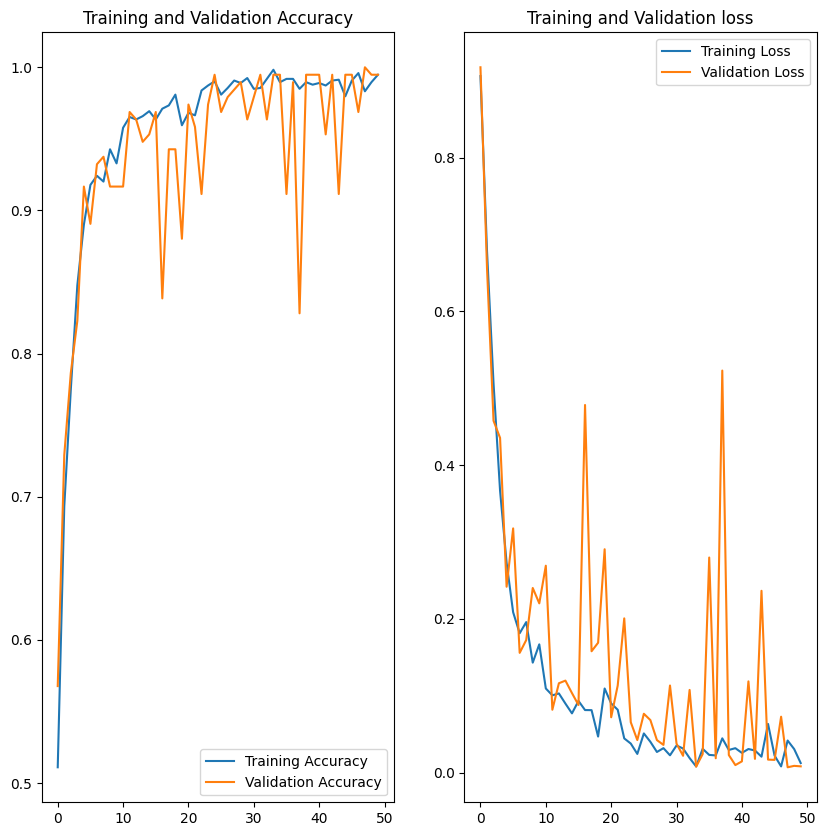

In [52]:
# plot the loss and accuracy of the model

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")

First image to predict
Actual Label :  Potato___Early_blight
1/1 [==============================] - 0s 381ms/step
Predicted label :  Potato___Early_blight


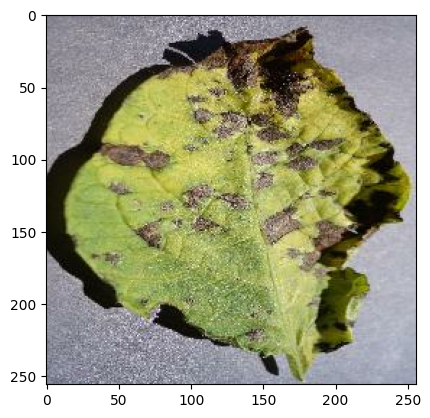

In [63]:
import numpy as np

for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label : ",classes_name[label_batch[0].numpy()])

    batch_prediction=model.predict(image_batch)
    print("Predicted label : ",classes_name[np.argmax(batch_prediction[0])])

In [69]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)  #create a batch

    prediction = model.predict(img_array)
    predicted_class=classes_name[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    return predicted_class,confidence



1/1 [==============================] - 0s 30ms/step


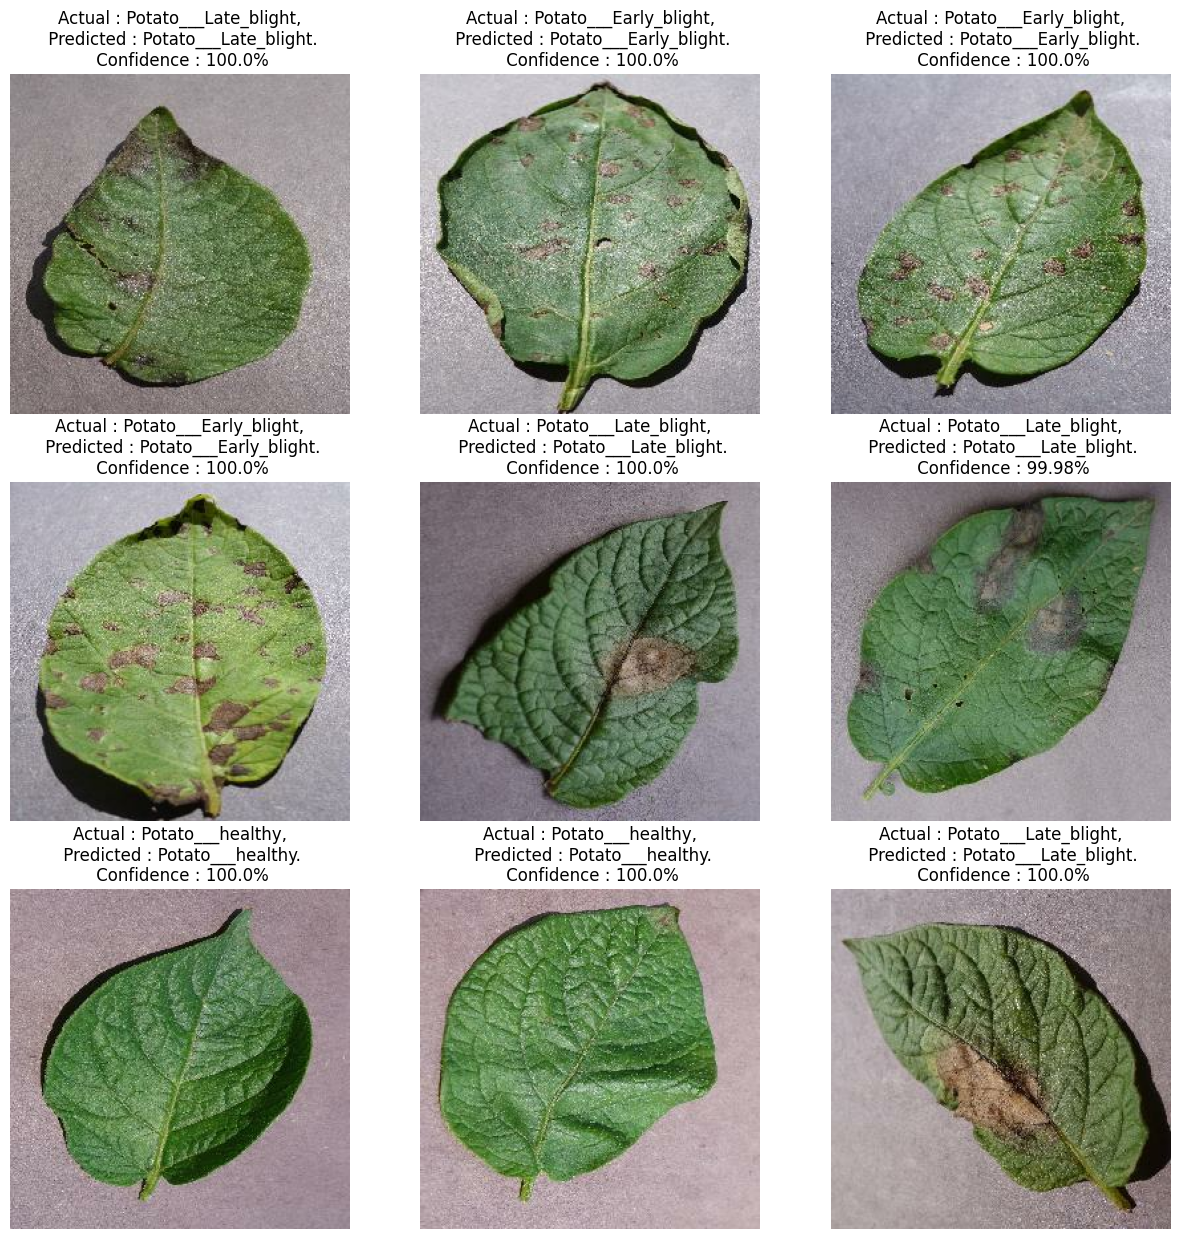

In [74]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=classes_name[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}.\n Confidence : {confidence}%")
        plt.axis('off')

In [73]:
model.save("potato_model.h5")


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
